### Import Libraries


In [27]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
import csv

np.random.seed(10)
warnings.filterwarnings('ignore', category=RuntimeWarning)

### MLP Class


In [28]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.weights_input_hidden = np.random.rand(
            self.input_size, self.hidden_size) * 2 - 1
        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = np.random.rand(
            self.hidden_size, self.output_size) * 2 - 1
        self.bias_output = np.zeros((1, self.output_size))

    def bipolar_sigmoid(self, x):
        return 2 * (1 / (1 + np.exp(-x))) - 1

    def bipolar_sigmoid_derivative(self, x):
        return 0.5 * (1 + self.bipolar_sigmoid(x)) * (1 - self.bipolar_sigmoid(x))

    def forward_propagation(self, inputs):
        hidden_layer_input = np.dot(
            inputs, self.weights_input_hidden) + self.bias_hidden
        hidden_layer_output = self.bipolar_sigmoid(hidden_layer_input)

        output_layer_input = np.dot(
            hidden_layer_output, self.weights_hidden_output) + self.bias_output
        output_layer_output = self.bipolar_sigmoid(output_layer_input)

        return hidden_layer_output, output_layer_output

    def backpropagation(self, inputs, targets, learning_rate):
        hidden_layer_output, output_layer_output = self.forward_propagation(
            inputs)

        output_error = targets - output_layer_output
        output_delta = output_error * \
            self.bipolar_sigmoid_derivative(output_layer_output)

        hidden_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_delta = hidden_error * \
            self.bipolar_sigmoid_derivative(hidden_layer_output)

        self.weights_hidden_output += hidden_layer_output.reshape(-1, 1).dot(
            output_delta.reshape(1, -1)) * learning_rate
        self.bias_output += output_delta * learning_rate

        self.weights_input_hidden += inputs.reshape(-1, 1).dot(
            hidden_delta.reshape(1, -1)) * learning_rate
        self.bias_hidden += hidden_delta * learning_rate

    def fit(self, inputs, targets, epochs, learning_rate):
        for _ in range(epochs):
            for i in range(len(inputs)):
                input_vector = inputs[i]
                target_vector = targets[i]

                self.backpropagation(
                    input_vector, target_vector, learning_rate)

    def predict(self, inputs):
        _, output = self.forward_propagation(inputs)
        return output

### Preparing Data


In [29]:
def get_dataset(path):
    df = pd.read_csv(path, sep=',', header=None)
    X = df.iloc[:, :-1].values
    Y = df.iloc[:, -1].values
    Y = LabelEncoder().fit_transform(Y)
    s = np.full((26, 26), -1)
    np.fill_diagonal(s, 1)
    Y = s[Y]
    return X, Y

In [30]:
X_train, y_train = get_dataset('./data/train/alphabet_dataset.txt')
X_test10, y_test10 = get_dataset('./data/test/letter10error.txt')
X_test15, y_test15 = get_dataset('./data/test/letter15error.txt')
X_test20, y_test20 = get_dataset('./data/test/letter20error.txt')

### Running Tests on MLP

testing the model with:

- learning rate = 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0

- epoch = 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000

- hidden layer size = 10, 15, 20, 25, 30

#### and saving the results as csv


In [31]:
results = []

for lr in range(1, 11, 1):
    for hidden_size in range(10, 35, 5):
        for epochs in range(100, 1100, 100):
            print(lr, hidden_size, epochs, end='  \r')
            mlp = MLP(input_size=63, hidden_size=hidden_size,
                      output_size=26)
            mlp.fit(X_train, y_train, epochs=epochs, learning_rate=lr/10)

            prediction = mlp.predict(X_train)
            nr_correct = np.sum(
                np.argmax(prediction, axis=1) == np.argmax(y_train, axis=1))
            train_accuracy = (nr_correct / X_train.shape[0]) * 100

            prediction = mlp.predict(X_test10)
            nr_correct = np.sum(
                np.argmax(prediction, axis=1) == np.argmax(y_test10, axis=1))
            test_accuracy_10 = (nr_correct / X_test10.shape[0]) * 100

            prediction = mlp.predict(X_test15)
            nr_correct = np.sum(
                np.argmax(prediction, axis=1) == np.argmax(y_test15, axis=1))
            test_accuracy_15 = (nr_correct / X_test15.shape[0]) * 100

            prediction = mlp.predict(X_test20)
            nr_correct = np.sum(
                np.argmax(prediction, axis=1) == np.argmax(y_test20, axis=1))
            test_accuracy_20 = (nr_correct / X_test20.shape[0]) * 100

            results.append({
                'Learning Rate': lr/10,
                'Hidden Layer Size': hidden_size,
                'Epochs': epochs,
                'Train Accuracy': train_accuracy,
                'Test Accuracy 10': test_accuracy_10,
                'Test Accuracy 15': test_accuracy_15,
                'Test Accuracy 20': test_accuracy_20
            })

csv_file_path = 'test_results.csv'

with open(csv_file_path, 'w', newline='') as csv_file:
    fieldnames = ['Learning Rate', 'Hidden Layer Size',
                  'Epochs', 'Train Accuracy', 'Test Accuracy 10',
                  'Test Accuracy 15', 'Test Accuracy 20']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()

    for result in results:
        writer.writerow(result)

print(f'Results saved to {csv_file_path}')

Results saved to test_results.csv


### Test Results


In [32]:
df = pd.read_csv('test_results.csv')
df

,Learning Rate,Hidden Layer Size,Epochs,Train Accuracy,Test Accuracy 10,Test Accuracy 15,Test Accuracy 20
0,0.1,10,100,92.307692,30.769231,34.615385,23.076923
1,0.1,10,200,98.717949,26.923077,34.615385,34.615385
2,0.1,10,300,98.717949,34.615385,42.307692,26.923077
3,0.1,10,400,100.000000,34.615385,34.615385,26.923077
4,0.1,10,500,100.000000,42.307692,26.923077,26.923077
...,...,...,...,...,...,...,...
495,1.0,30,600,100.000000,53.846154,61.538462,50.000000
496,1.0,30,700,100.000000,61.538462,61.538462,42.307692
497,1.0,30,800,100.000000,69.230769,53.846154,50.000000
498,1.0,30,900,100.000000,57.692308,61.538462,57.692308


### Visualising The Results


In [33]:
def line_plot(data_name):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.lineplot(x='Learning Rate', y=data_name, data=df)
    plt.title(f'{data_name} vs Learning Rate')

    plt.subplot(1, 3, 2)
    sns.lineplot(x='Hidden Layer Size', y=data_name, data=df)
    plt.title(f'{data_name} vs Hidden Layer Size')

    plt.subplot(1, 3, 3)
    sns.lineplot(x='Epochs', y=data_name, data=df)
    plt.title(f'{data_name} vs Epochs')

    plt.tight_layout()
    plt.show()

### Train Accuracy


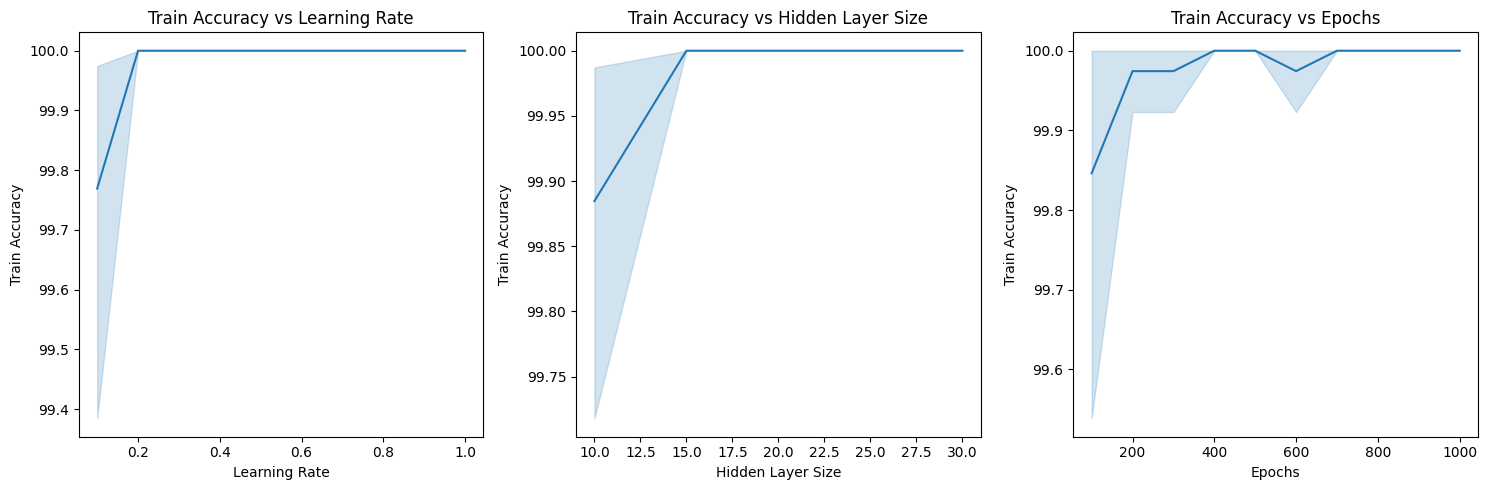

In [34]:
line_plot('Train Accuracy')

### Test 10% Results


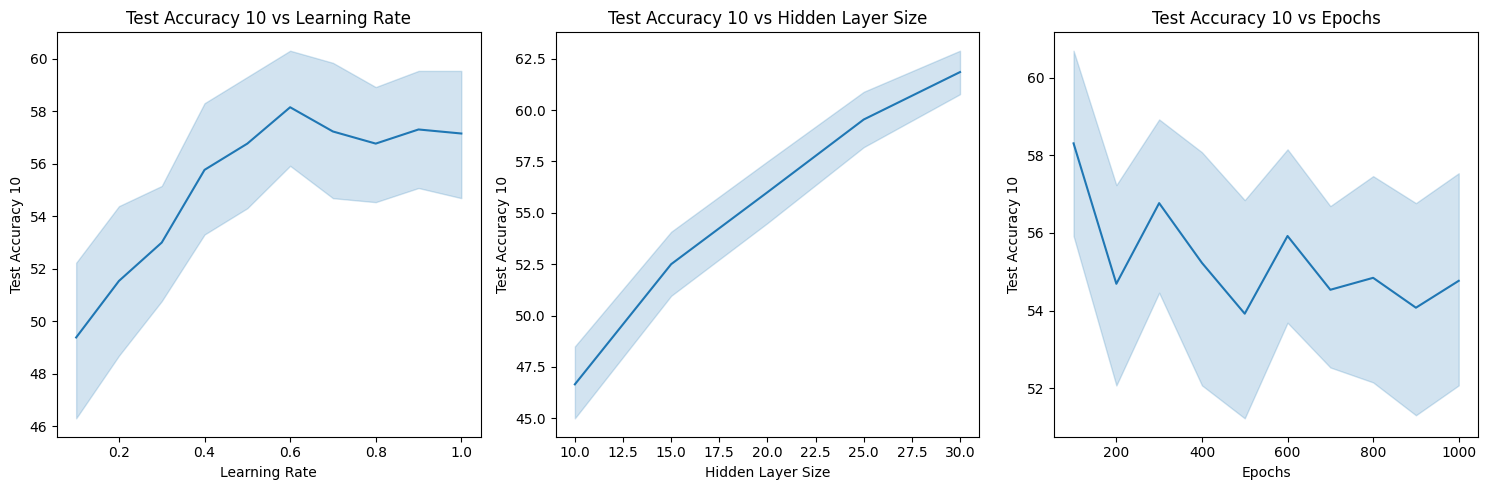

In [35]:
line_plot('Test Accuracy 10')

### Test 15% Results


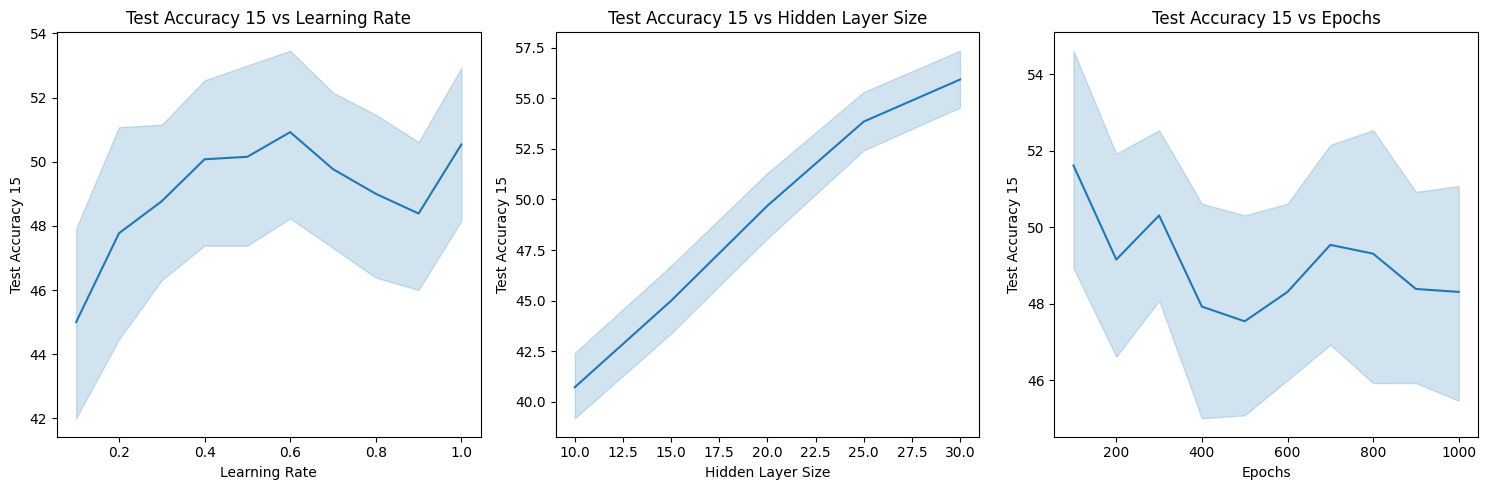

In [36]:
line_plot('Test Accuracy 15')

### Test 20% Results


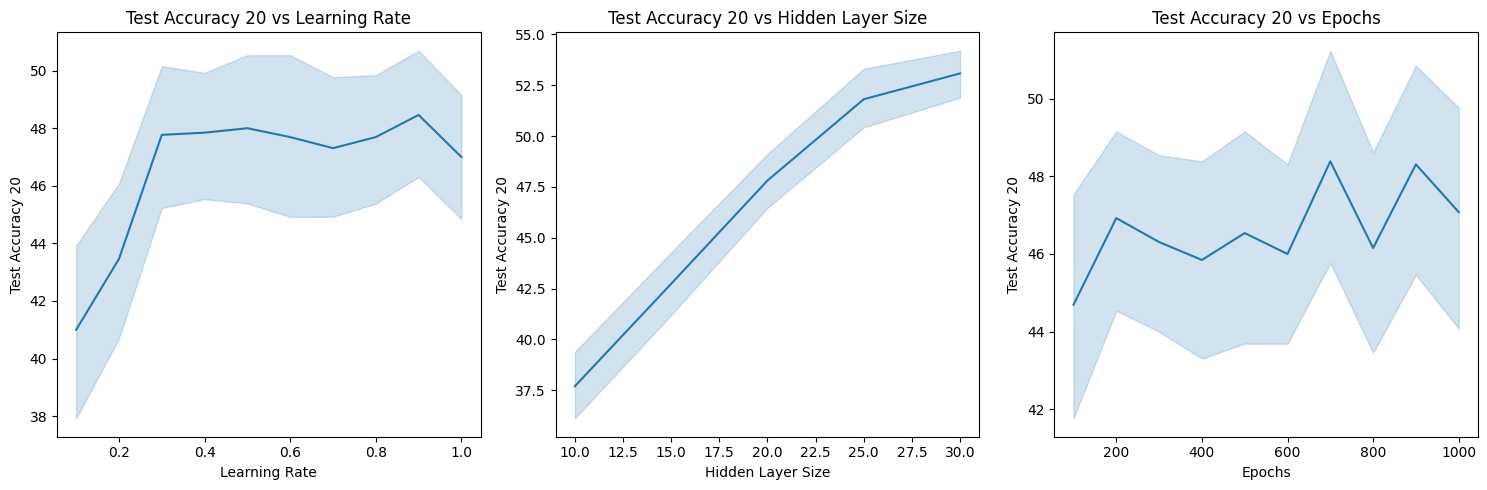

In [37]:
line_plot('Test Accuracy 20')